In [1]:
import pandas as pd
import numpy as np
import io
import os

import matplotlib.pyplot as plt

import xgboost as xgb
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from pipeline import transform_events

from sklearn.metrics import classification_report
from sklearn.utils.fixes import loguniform
from scikitplot.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTENC

from scipy.stats import uniform, expon 

SEED = 42
np.random.seed(SEED)

from category_encoders import GLMMEncoder

/opt/anaconda3/envs/xGoals/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = transform_events()

Optimization terminated successfully.
         Current function value: 0.646144
         Iterations 9


In [7]:
X = df[['red_card_home_cum', 'red_card_away_cum', 'yellow_card_home_cum', 'yellow_card_away_cum',
        'attacks_home_cum', 'attacks_away_cum', 'dangerous_attacks_home_cum', 'dangerous_attacks_away_cum',
        'quarter', 'distance', 'angle', 'angle_over_distance', 'turnover_cum', 'header', 'penalty',#'shot', 
        'preceding_corner', 'preceding_freekick', 'preceding_save', #'preceding_other', 
        'preceding_blocked_shot', 'preceding_dangerous_attack', 'preceding_penalty', 
        'on_target_pred', 'goal_diff', 'goals_up_x_remaining', 'is_home', 'home_lead', 'away_lead',
        'is_in_penalty_area', 'is_in_goal_area', 'weather_condition', 'pitch_condition'
]]

y = df['goal']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)

In [9]:
# Post procsessing. Drop nans in train, set them to mean in test
drop_mask = ~(X_train['distance'].isna() | X_train['angle'].isna())
X_train, y_train = X_train[drop_mask], y_train[drop_mask]

X_test.loc[X['distance'].isna(), 'distance'] = X_test['distance'].mean()
X_test.loc[X['angle'].isna(), 'angle'] = X_test['angle'].mean()

In [ ]:
# CV fit (don't run ~40min)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 4, 5],
    'gamma': [0, 1, 10],
    'reg_lambda': [0.5, 1, 5, 10],
    'scale_pos_weight': [0.15, 6.5], # Ratio between samples
    'subsample': [0.5, 1] 
}

cv = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, seed=SEED, verbose=0), 
    param_grid=param_grid, scoring='neg_log_loss', verbose=0
)
cv.fit(X_train, y_train)

In [7]:
cv.best_params_

{'gamma': 0,
 'learning_rate': 0.5,
 'max_depth': 5,
 'reg_lambda': 10,
 'scale_pos_weight': 6.5,
 'subsample': 1}

In [10]:
load_model = True
if load_model:
    cl = xgb.XGBClassifier()
    cl.load_model('model.txt')
    cl.fit(X_train, y_train)
else:
    best_params = {
        'gamma': 0,
        'learning_rate': 0.5,
        'max_depth': 5,
        'reg_lambda': 5,
        'scale_pos_weight': 6.5,
        'subsample': 1
    }
    cl = xgb.XGBClassifier(param_grid=cv.best_params_, use_label_encoder=False, seed=SEED, verbose=0)
    cl.fit(X_train, y_train)
    cl.save_model('model.txt')


/opt/anaconda3/envs/xGoals/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:04:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "param_grid", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:04:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [11]:
y_pred = cl.predict(X_test)
(y_pred == y_test).mean()

0.9174233825198638

In [13]:
mean_absolute_error(y_pred, y_test)

0.08257661748013621

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

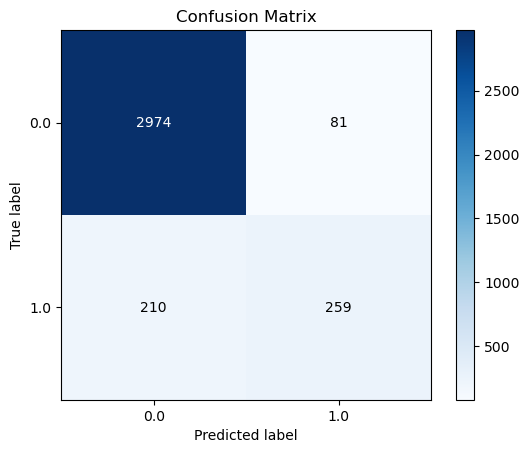

In [15]:
plot_confusion_matrix(y_test, y_pred)

/opt/anaconda3/envs/xGoals/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


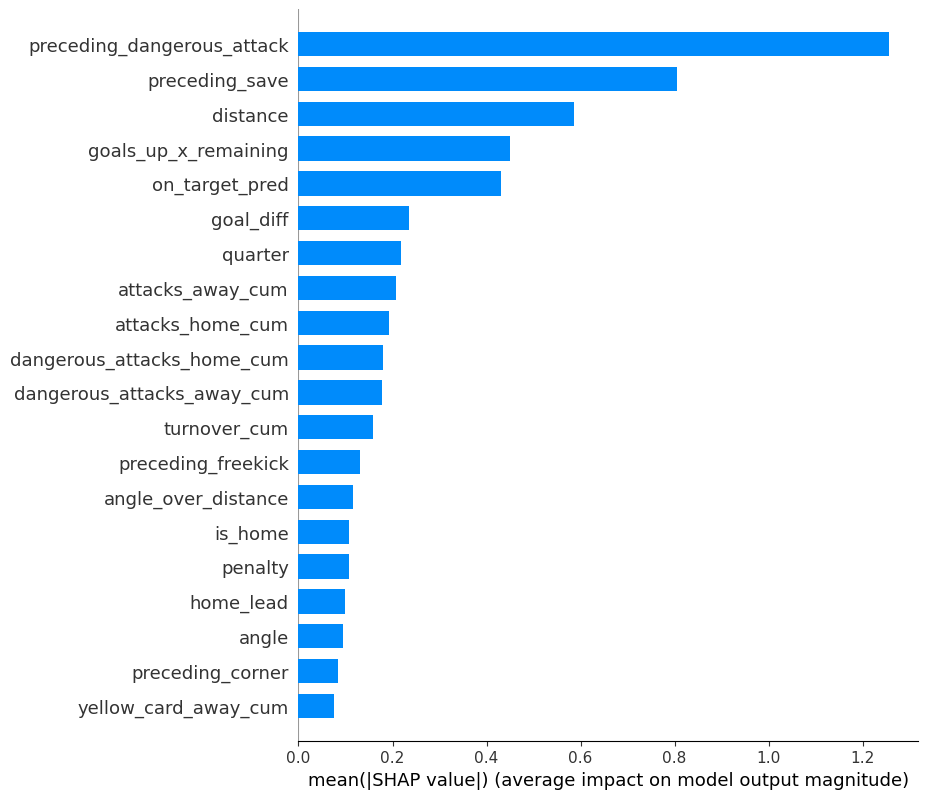

In [16]:
import shap

explainer = shap.TreeExplainer(cl)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')